### Resources
#### https://catalog.data.gov/dataset/census-api-by-coordinates
#### https://www.programmableweb.com/category/all/apis?keyword=zip%20code
#### https://www.census.gov/geo/maps-data/data/geocoder.html
#### https://www.census.gov/data/developers/data-sets/popest-popproj.html
#### https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf

In [14]:
#import libraries and api keys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import requests
import json
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

## Gather Zip Codes within 20 mile radius of city

In [15]:
# Create a dictionary of the cities' names and their zipcodes
cities = {'Cleveland':44114,
          'LA': 90071,
          'Austin': 78705,
          'NYC': 10019,
          'Denver': 80202
         }
# APi key for https://www.zipcodeapi.com/API
api = "F1Q5equ8jewDKQnEnJ5o2SYzmUj0WJr7wjbvYlHLG1xlGqrc5XNzVYYRC4RB3cT1"

# Loop through the cities to get the required zip_code
for city in cities:
    # Create an api request from the website 
    data_1 = requests.get(f"https://www.zipcodeapi.com/rest/F1Q5equ8jewDKQnEnJ5o2SYzmUj0WJr7wjbvYlHLG1xlGqrc5XNzVYYRC4RB3cT1/radius.csv/{cities[city]}/20/mile")
    
    # Create an empty list to save the results later
    zipcode_data = []
    # Get the text as str for further processing and slpit them
    text = data_1.text
    for row in text.split('\n'):
        zipcode_data.append(row.split(','))
    
    # Create a data Frame for the results collected from preivous step
    df = pd.DataFrame(zipcode_data)
    #Set the columns index 
    df = df.set_axis(['zip_code','distance','city','state'], axis='columns', inplace=False)
    # Drop the first row which contains unnecessarily string data
    df = df.drop(0)
    # Convert to a numeric data from distance
    df['distance'] = pd.to_numeric(df['distance'])
    # Sort the values by ascending order
    df = df.sort_values(by='distance', ascending=True)
    # Save it to a csv file by the city name
    df.to_csv(f'Zipcodes/{city}.csv')

## Merge zip codes, ZCTA and median age data into single dataframe

In [16]:
#define city function
def city_age(city_name):

    #load in csv files for each city
    city_file = "Zipcodes/" + city_name + ".csv"
    city_df = pd.read_csv(city_file)
    city_df = city_df.drop(city_df.columns[0], axis=1)
    city_df['zip_code'] = city_df['zip_code'].astype(str).str[:-2]

    #https://www.udsmapper.org/zcta-crosswalk.cfm
    #load in csv for ZTAC info
    zip_file = "Zipcodes/zip_to_zcta_2018.csv"
    zip_df = pd.read_csv(zip_file)

    #convert zip code to string to add back zeroes
    zip_df["zip_code"] = zip_df["zip_code"].astype(str)

    for index, row in zip_df.iterrows():
    
        length = len(zip_df.at[index, "zip_code"])
        ZIP = zip_df.at[index, "zip_code"]
    
        if (5 - length) == 2:
            new_zip = "00" + ZIP
            zip_df.at[index, "zip_code"] = new_zip
        else:
            if (5 - length) == 1:
                new_zip = "0" + ZIP
                zip_df.at[index, "zip_code"] = new_zip

    #convert zcta to string to add back zeroes
    zip_df["zcta"] = zip_df["zcta"].astype(str)

    for index, row in zip_df.iterrows():
    
        length = len(zip_df.at[index, "zcta"])
        ZCTA = zip_df.at[index, "zcta"]
    
        if (5 - length) == 2:
            new_zcta = "00" + ZCTA
            zip_df.at[index, "zcta"] = new_zcta
        else:
            if (5 - length) == 1:
                new_zcta = "0" + ZCTA
                zip_df.at[index, "zcta"] = new_zcta
            
    #join ZCTA data to city df
    df_merge = pd.merge(city_df, zip_df, on="zip_code")

    #create data frame for zip to zcta mapping
    age_file = "Zipcodes/DEC_10_SF1_QTP1_with_ann.csv"
    age_df = pd.read_csv(age_file)

    #convert zcta to string to add back zeroes
    age_df["zcta"] = age_df["zcta"].astype(str)

    for index, row in age_df.iterrows():
    
        length = len(age_df.at[index, "zcta"])
        ZCTA2 = age_df.at[index, "zcta"]
    
        if (5 - length) == 2:
            new_zcta2 = "00" + ZCTA2
            age_df.at[index, "zcta"] = new_zcta2
        else:
            if (5 - length) == 1:
                new_zcta2 = "0" + ZCTA2
                age_df.at[index, "zcta"] = new_zcta2

    df_final= pd.merge(df_merge, age_df, on="zcta")
    clean_df = df_final[df_final["median age"] != 0]
    clean_df.reset_index(inplace=True, drop=True)
    return clean_df.head()

## Create Dataframe for each City

In [17]:
aus_df = city_age("Austin")
cle_df = city_age("Cleveland")
den_df = city_age("Denver")
nyc_df = city_age("NYC")
la_df = city_age("LA")
la_df

,zip_code,distance,city,state,zcta,median age
0,90071,0.000,"""Los Angeles""","""CA""",90071,45.5
1,90074,0.355,"""Los Angeles""","""CA""",90071,45.5
2,90081,0.355,"""Los Angeles""","""CA""",90017,29.4
3,90084,0.355,"""Los Angeles""","""CA""",90017,29.4
4,90088,0.355,"""Los Angeles""","""CA""",90017,29.4


# Create Function for plot, Analysis, and ANOVA

In [18]:
# Create function that do scatter plot for the city distance and median age
def plot_city(city):
    plt.scatter(city['distance'],city['median age'])
    plt.xlabel('Distance (mile)')
    plt.ylabel('Median Age')
    city_row = city[city['distance'] == 0]
    city_name = city['city'].reset_index(level=0)
    city_name = city_name.values[0,1]
    plt.title(f'City: {city_name} Median Age vs Distance')
    plt.grid()

def Regression(city):
    
    X_train, X_test, y_train, y_test = train_test_split(city['distance'],city['median age'],test_size= 0.2, random_state = 1)

    # Model to fit a linear line
    model = LinearRegression()

    model.fit((X_train[:, np.newaxis]),y_train)
    xfit = np.linspace(0, 20,20 )
    yfit = model.predict(xfit[:, np.newaxis])
    print(f'model coefficient: {int(model.coef_)}')
    print(f'model intercept: {int(model.intercept_)}')
    y_predict = model.predict(X_test[:, np.newaxis])
    print (f'R_squared is: {r2_score(y_test,y_predict)}')
    
    plt.scatter(X_train,y_train)
    plt.plot(xfit, yfit, 'r-')
    plt.xlabel('Distance (mile)')
    plt.ylabel('Median Age')
    city_row = city[city['distance'] == 0]
    city_name = city['city'].reset_index(level=0)
    city_name = city_name.values[0,1].replace('"','')
    plt.title(f'City: {city_name} Median Age vs Distance')
    plt.grid()
    plt.savefig(f'{city_name}.png')
    plt.show()

def Poly_regress(city):
    X_train, X_test, y_train, y_test = train_test_split(city['distance'],city['median age'],test_size= 0.2, random_state = 1)
    model_2 = make_pipeline(PolynomialFeatures(2),LinearRegression())
    model_2.fit((X_train[:, np.newaxis]),y_train)
    xfit = np.linspace(0, 20,20 )
    yfit = model_2.predict(xfit[:, np.newaxis])
    print(model_2.steps[1][1].coef_)
    print(model_2.steps[1][1].intercept_)
    # print(f'model coefficient: {int(model_2.coef_)}')
    # print(f'model intercept: {int(model_2.intercept_)}')
    y_predict = model_2.predict(X_test[:, np.newaxis])
    print (f'R_squared is: {r2_score(y_test,y_predict)}')
    plt.scatter(X_train,y_train)
    plt.plot(xfit, yfit)
    city_row = city[city['distance'] == 0]
    city_name = city['city'].reset_index(level=0)
    city_name = city_name.values[0,1].replace('"','')
    plt.savefig(f'{city_name}.png')

def ANOVA(city, degree=1):
 
    # diabetes = datasets.load_diabetes()
    X = city['distance']
    X_2 = X**2
    X_1=pd.DataFrame([X]).T
    if degree > 1 :
        for degrees in range(1,degree):
            X_1 [f'distance_{degrees}'] = X_1['distance']**degrees
        
    # X_1 ['distance_3'] = X_1['distance']**3
    y = pd.DataFrame(city['median age'])
    X2 = sm.add_constant(X_1)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    summary = est2.summary()
#     city_row = city[city['distance'] == 0]
#     city_name = city['city'].reset_index(level=0)
#     city_name = city_name.values[0,1]
#     file = open(f'{city_name}.txt','w') 
#     file.write(f'{summary}') 
#     file.close() 
    print(est2.summary())
    return summary

### Cleveland Analysis

                            OLS Regression Results                            
Dep. Variable:             median age   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.318
Method:                 Least Squares   F-statistic:                   0.03465
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.864
Time:                        12:41:59   Log-Likelihood:                -16.636
No. Observations:                   5   AIC:                             37.27
Df Residuals:                       3   BIC:                             36.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.4594      7.533      4.707      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


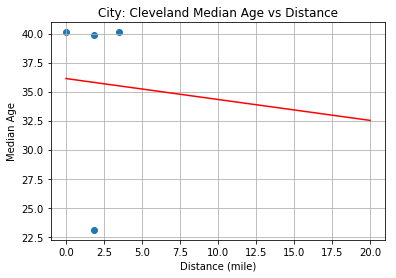

In [25]:
ANOVA(cle_df,degree=1)
Regression(cle_df)

### Denver Analysis

                            OLS Regression Results                            
Dep. Variable:             median age   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -3.000
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               1.00
Time:                        12:40:05   Log-Likelihood:                 151.77
No. Observations:                   5   AIC:                            -299.5
Df Residuals:                       3   BIC:                            -300.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.3000   2.05e-14   1.57e+15      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


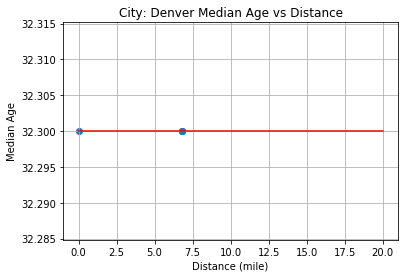

In [20]:
ANOVA(den_df,degree=1)
Regression(den_df)

### NYC Analysis

                            OLS Regression Results                            
Dep. Variable:             median age   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -3.000
Date:                Tue, 18 Sep 2018   Prob (F-statistic):               1.00
Time:                        12:40:07   Log-Likelihood:                 153.41
No. Observations:                   5   AIC:                            -302.8
Df Residuals:                       3   BIC:                            -303.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.0000   1.48e-14    2.5e+15      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


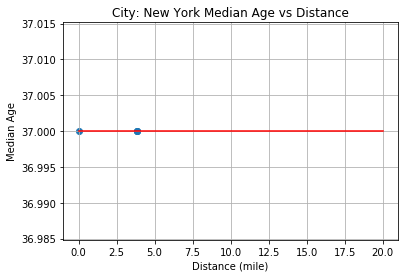

In [21]:
ANOVA(nyc_df,degree=1)
Regression(nyc_df)

### LA Analysis

                            OLS Regression Results                            
Dep. Variable:             median age   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     1.800
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.272
Time:                        12:40:08   Log-Likelihood:                -16.246
No. Observations:                   5   AIC:                             36.49
Df Residuals:                       3   BIC:                             35.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.5000      8.050      5.652      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


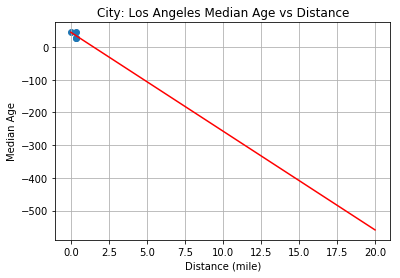

In [22]:
ANOVA(la_df,degree=1)
Regression(la_df)

### Austin Analysis

                            OLS Regression Results                            
Dep. Variable:             median age   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.309
Method:                 Least Squares   F-statistic:                   0.05468
Date:                Tue, 18 Sep 2018   Prob (F-statistic):              0.830
Time:                        12:40:10   Log-Likelihood:                -15.327
No. Observations:                   5   AIC:                             34.65
Df Residuals:                       3   BIC:                             33.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.9875      5.695      4.037      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


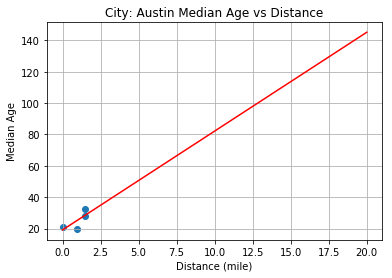

In [23]:
ANOVA(aus_df,degree=1)
Regression(aus_df)